<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Tunning </h1> 
</div>

![](img/header.png)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

O objetivo neste notebook é criação novas variáveis (features) que possam ajudar na identificação de novos padrões, com a finalidade de bater a baseline estabelecida no [notebook anterior](https://github.com/rogeriodelfim/Competicoes/blob/main/Flai/10/02%20-%20Features%20Engineering.ipynb) com XGBoost na competição. 



<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q colorama
    !pip install --q tensorflow
    !pip install --q wandb
    !pip install --q eli5
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [235]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import shap
import multiprocessing
import glob
import scipy.optimize 
import scipy.special
import optuna

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import scipy.stats       as stats
import statsmodels.api   as sm
import xgboost           as xgb
import scikitplot        as skplt
import category_encoders as ce

In [4]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer 
from sklearn.preprocessing   import PowerTransformer, Normalizer
from sklearn.preprocessing   import LabelBinarizer, OneHotEncoder, OrdinalEncoder
from sklearn                 import metrics
from sklearn.metrics         import ConfusionMatrixDisplay, confusion_matrix
from datetime                import datetime

In [5]:
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA

In [6]:
from matplotlib.axes._axes   import _log as matplotlib_axes_logger
from sklearn.ensemble        import VotingRegressor
from sklearn.compose         import TransformedTargetRegressor
from sklearn.pipeline        import Pipeline
from scipy.stats             import skew, norm
from scipy.stats             import norm

In [7]:
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from sklearn.utils.class_weight import compute_sample_weight
from scipy                      import stats
from scipy.cluster              import hierarchy as hc
from math                       import factorial
from scipy.stats                import mode
from collections                import Counter
from sklearn.neighbors          import KNeighborsClassifier
#from optbinning                 import OptimalBinning

In [8]:
from yellowbrick.regressor       import ResidualsPlot
from yellowbrick.regressor       import PredictionError
from yellowbrick.model_selection import ValidationCurve

In [9]:
from datetime                  import datetime
from scipy.stats               import skew, norm
from collections               import Counter
from sklearn.model_selection   import RandomizedSearchCV, GridSearchCV
from sklearn.calibration       import CalibrationDisplay
from colorama                  import Fore, Back, Style
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline          import Pipeline, make_pipeline, FeatureUnion

In [10]:
from sklearn.compose      import TransformedTargetRegressor
from sklearn.pipeline     import FeatureUnion, Pipeline, make_pipeline
from sklearn.base         import BaseEstimator, TransformerMixin

In [11]:
from sklearn.compose            import ColumnTransformer, make_column_transformer
from sklearn.pipeline           import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_selection  import VarianceThreshold
from sklearn.impute             import SimpleImputer
from scipy.stats                import chi2_contingency
from plotly.subplots            import make_subplots
from sklearn.base               import BaseEstimator, RegressorMixin, TransformerMixin, clone

In [12]:
from sklearn.metrics           import precision_score
from sklearn.metrics           import accuracy_score
from sklearn.metrics           import recall_score
from sklearn.metrics           import fbeta_score
from sklearn.metrics           import f1_score
from sklearn.metrics           import log_loss
from sklearn.impute            import SimpleImputer
from category_encoders          import TargetEncoder

In [13]:
from imblearn.over_sampling     import SMOTE
from imblearn.under_sampling    import RandomUnderSampler
from sklearn.ensemble           import RandomForestClassifier

In [14]:
from matplotlib.axes._axes     import _log as matplotlib_axes_logger
from sklearn.model_selection   import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing     import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.preprocessing     import MaxAbsScaler, QuantileTransformer 
from sklearn.preprocessing     import PowerTransformer, Normalizer
from sklearn.preprocessing     import LabelBinarizer, OneHotEncoder, OrdinalEncoder
from sklearn                   import metrics
from sklearn.metrics           import make_scorer
from sklearn.metrics           import roc_auc_score, f1_score, log_loss, roc_curve, auc
from sklearn.metrics           import classification_report, confusion_matrix
from sklearn.mixture           import GaussianMixture, BayesianGaussianMixture

In [ ]:
from optuna.samplers               import TPESampler
from optuna.visualization          import plot_edf
from optuna.visualization          import plot_optimization_history
from optuna.visualization          import plot_parallel_coordinate
from optuna.visualization          import plot_param_importances
from optuna.visualization          import plot_slice
from optuna.visualization          import plot_intermediate_values
from optuna.visualization          import plot_contour
from optuna.pruners                import MedianPruner
from optuna.pruners                import BasePruner
from optuna.trial._state           import TrialState

## 1.3. Funções

Abaixo foi criado uma classe com diversas funções, que será utilizada nos processos e modelagem.

In [22]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

        pd.options.mode.chained_assignment = None 
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
    
    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = 1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = 1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = 1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = 1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

    def smape_(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
                    
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [23]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()

In [24]:
def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))

In [343]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_submission_, 
                    score_, seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            df_submission[target_] = y_pred_test_submission_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [344]:
def plot_metric(result):
    plt.figure(figsize=(16, 4))
    
    for i, metric in enumerate(['logloss']):
        plt.subplot(1, 2, i+1)
        train_metric = result['train'][metric]
        plt.plot(train_metric, label=f'train {metric}')
        eval_metric = result['valid'][metric]
        plt.plot(eval_metric, label=f'valid {metric}')
        plt.grid()
        plt.legend()
        plt.xlabel('rounds')
        plt.ylabel(f'{metric}')
    plt.show()

In [345]:
def model_cv_fit(models_, X_, y_, X_test_, path_, target_, seed_=12359, print_report_=False,
                 n_splits_=5, print_hist_=False, create_sub_=False, save_ensamble_=True,
                 model_feature_=None, is_tunning_=False):
    
    cols         = []
    cols_score   = []
    mdl_list_fit = []
    tag          = 90
    oof_train    = np.zeros((len(X_), len(models_)))
    score_mdl    = np.zeros(len(models_),)
    oof_test     = np.zeros((len(X_test_), len(models_)))
    kf           = StratifiedKFold(shuffle=True, n_splits=n_splits_, random_state=seed_)
    
    for i, m in enumerate(models_):
        
        time_start       = datetime.now()
        model            = m[1]
        type_model       = m[2]
        name_sub         = m[3]
        n_estimators     = m[5]
        score_list       = []
        score_list_f1    = []
        score_list_f1_tr = []
        y_ts_pred        = 0 
                
        
        if is_tunning_ is False:
            delete_files(name_sub)
            print()
            print('=> {}'.format(m[0]))
            print('='*tag)

        for fold, (idx_tr, idx_va) in enumerate(kf.split(X_, y_)):
            
            time_fold_start = datetime.now()
            X_ts            = X_test_.copy()
            
            X_tr = X_.iloc[idx_tr]
            X_va = X_.iloc[idx_va]
            y_tr = y_.iloc[idx_tr]
            y_va = y_.iloc[idx_va]
            
            if model_feature_ is not None:
                X_tr_ = X_tr.copy()
                X_va_ = X_va.copy()
                X_ts_ = X_ts.copy()
                if model_feature_[1] is not None:
                    X_tr_ = model_feature_[1].fit_transform(X_tr, y_tr)
                    X_va_ = model_feature_[1].transform(X_va)
                    X_ts_ = model_feature_[1].transform(X_ts)
                    
                model_feature_[0].fit(X_tr_, y_tr)
                
                X_tr['fe_model'] = model_feature_[0].predict_proba(X_tr_)[:,1]
                X_va['fe_model'] = model_feature_[0].predict_proba(X_va_)[:,1]
                X_ts['fe_model'] = model_feature_[0].predict_proba(X_ts_)[:,1]
            
            if type_model==1:
                model.fit(X_tr, y_tr)

            if type_model==2:
                pp_processor = m[4]
                X_tr = pp_processor.fit_transform(X_tr, y_tr)
                X_va = pp_processor.transform(X_va)
                X_ts = pp_processor.transform(X_ts)
                
                model.fit(X_tr, y_tr,
                          model__eval_set=[(X_va, y_va)],
                          #model__eval_metric ='binary_logloss',
                          #model__callbacks=[early_stopping_rounds=100]
                          model__early_stopping_rounds=50,
                          model__verbose              = False)
            
            if type_model==3:
                model.fit(X_tr, y_tr,
                          eval_set              = [(X_tr, y_tr), (X_va, y_va)],
                          early_stopping_rounds = int(n_estimators*.3),
                          verbose               = False)
                                
            if type_model==4:
                pp_processor = m[4]
                X_tr = pp_processor.fit_transform(X_tr, y_tr)
                X_va = pp_processor.transform(X_va)
                X_ts = pp_processor.transform(X_test_.copy())
                model.fit(X_tr, y_tr,
                          eval_set              = [(X_tr, y_tr), (X_va, y_va)],
                          early_stopping_rounds = int(n_estimators*.3),
                          verbose               = False)
            
            y_va_pred  = model.predict_proba(X_va)[:,1]
            y_tr_pred  = model.predict_proba(X_tr)[:,1]
            y_ts_pred += model.predict_proba(X_ts)[:,1]/kf.n_splits
            
            logloss    = log_loss(y_va, y_va_pred)
            f1         = f1_score(y_va, (y_va_pred>.5).astype(int))
            f1_tr      = f1_score(y_tr, (y_tr_pred>.5).astype(int))
            roc_auc    = roc_auc_score(y_va, (y_va_pred>.5).astype(int))
            
            oof_train[idx_va, i] = y_va_pred
            
            time_fold_end = utility.diff(time_fold_start, datetime.now())
            
            if is_tunning_ is False:
                msg = "Fold {} => F1-score: {:2.5f} - F1-Train: {:2.5f} - AUC:{:2.5f} - L.Loss: {:2.5f} - {}"
                print(msg.format(fold+1, f1, f1_tr, roc_auc, logloss, time_fold_end))
            
            score_list_f1.append(f1)
            score_list_f1_tr.append(f1_tr)
            score_list.append(logloss)
            
            mdl_list_fit.append ([m[0], fold+1, model])

        oof_test[:,i]    = y_ts_pred
        score_mean       = np.mean(score_list).round(5)
        score_mean_f1    = np.mean(score_list_f1).round(5)
        score_mean_f1_tr = np.mean(score_list_f1_tr).round(5)
                
        if print_hist_: 
            plot_oof_histogram(m[0], oof_train)
        
        cols.append(m[0])
        cols_score.append(m[0]+'_'+str(score_mean_f1))
                
        if create_sub_:
            if target_ is None: target_=target
                
            if is_tunning_ is False:
                name_sub = name_sub+'_{:2.5f}_folds_{}_oof'.format(score_mean_f1, n_splits_)
            else: 
                name_sub = name_sub+'_{:2.5f}'.format(score_mean_f1)
                
            y_pred_test_sub = (oof_test[:,i]>.5).astype(int)
            
            y_pred_test_submission_=[]
            for num in y_pred_test_sub: 
                y_pred_test_submission_.append('não' if num==0 else 'sim')

            save_data_model(model_                  = model, 
                            model_name_             = name_sub, 
                            path_                   = path_, 
                            y_pred_train_prob_      = oof_train[:, i], 
                            y_pred_test_prob_       = oof_test[:,i], 
                            y_pred_test_submission_ = y_pred_test_submission_, 
                            score_                  = score_mean_f1, 
                            seed_                   = seed_, 
                            level_                  = '1', 
                            target_                 = target_, 
                            cutoff_value_           = .65, 
                            gera_submission_        = True)  
        
        score_mdl[i] = score_mean_f1
        
        time_end = utility.diff(time_start, datetime.now()) 
        
        msg = '{}{}[Mean] => F1-score: {:.5f} - F1-Train: {:.5f} - L.Loss: {:.5f} - {}{}'
        
        if is_tunning_ is False:
            print('-'*tag)
            print(msg.format(Fore.GREEN, Style.BRIGHT, score_mean_f1, score_mean_f1_tr, 
                             score_mean, time_end, Style.RESET_ALL)) 
            print('='*tag)

            if print_report_: 
                y_pred = (oof_train[:, i]>.5).astype(int)
                print()
                print(classification_report(y_, y_pred))
                print(confusion_matrix(y_, y_pred))    

        utility.free_gpu_cache()
    
    df_oof_tr    = pd.DataFrame(oof_train, columns=cols_score)
    df_oof_ts    = pd.DataFrame(oof_test, columns=cols_score) 
    df_score_mdl = pd.DataFrame(score_mdl, columns= ['score'])
    
    df_score_mdl.index = cols
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=False)
    
    if is_tunning_ is False:        
        if save_ensamble_:
            jb.dump(df_oof_tr, path_ + 'Data/pkl/df_pred_tr.pkl.z')
            jb.dump(df_oof_ts, path_ + 'Data/pkl/df_pred_ts.pkl.z');


        display(df_score_mdl)
        print()
    
    return mdl_list_fit, df_oof_tr, df_oof_ts, df_score_mdl, score_mean_f1

In [346]:
def evaluation(y_, predictions_):
    mae  = metrics.mean_absolute_error(y_, predictions_)
    mse  = metrics.mean_squared_error(y_, predictions_)
    rmse = metrics.mean_squared_error(y_, predictions_, squared=False) 
    mape = metrics.mean_absolute_percentage_error(y_, predictions_)
    r2   = metrics.r2_score(y_, predictions_)    
    return rmse, mae, mse, mape, r2

## 1.4. Criar estrutura de pasta 


In [33]:
path        = '/content/drive/MyDrive/Curso/Flai/10/' if COLAB else ''   
path_data   = 'Data/'  
target      = 'produto'
path_automl = 'automl/'

utility.create_fold(path)

## 1.5. Dataset

### 1.5.2. Carregar Dados

In [176]:
df1_train     = jb.load(path + path_data + 'pkl/df_train_fe.pkl.z')
df1_test      = jb.load(path + path_data + '/pkl/df_test_fe.pkl.z')
df_submission = pd.DataFrame({target: np.zeros(df1_test.shape[0])})
df1_train.shape, df1_test.shape, df_submission.shape

((5700, 16), (5700, 16), (5700, 1))

### 1.5.3. Visualizar os dados 

In [177]:
df1_train.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior,idade_group,fe_pca_0,fe_cluster_bgmm_pca,produto
0,escritório,casado(a),ensino médio,não,não,não,telefone fixo,junho,quinta-feira,média,1,nenhum,Acima_35_e_Menor_Igual_45,1.342401,1,0
1,trabalhador manual,casado(a),básico,NaN,não,não,telefone móvel,julho,terça-feira,média,4,nenhum,Entre_24_35,2.396623,1,0
2,especialista,casado(a),NaN,não,sim,não,telefone fixo,maio,segunda-feira,longa,1,nenhum,Acima_45_e_Menor_Igual_55,1.654042,1,0
3,especialista,solteiro(a),NaN,não,não,não,telefone móvel,outubro,terça-feira,longa,1,nenhum,Entre_24_35,-0.750118,2,0
4,escritório,solteiro(a),ensino técnico,não,NaN,NaN,telefone móvel,junho,quinta-feira,média,1,apenas um,Entre_24_35,-3.335624,0,1


In [178]:
df1_test.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior,idade_group,fe_pca_0,fe_cluster_bgmm_pca,produto
0,escritório,casado(a),ensino médio,não,não,não,telefone fixo,junho,quinta-feira,média,1,nenhum,Acima_35_e_Menor_Igual_45,1.342401,1,0
1,trabalhador manual,casado(a),básico,NaN,não,não,telefone móvel,julho,terça-feira,média,4,nenhum,Entre_24_35,2.396623,1,0
2,especialista,casado(a),NaN,não,sim,não,telefone fixo,maio,segunda-feira,longa,1,nenhum,Acima_45_e_Menor_Igual_55,1.654042,1,0
3,especialista,solteiro(a),NaN,não,não,não,telefone móvel,outubro,terça-feira,longa,1,nenhum,Entre_24_35,-0.750118,2,0
4,escritório,solteiro(a),ensino técnico,não,NaN,NaN,telefone móvel,junho,quinta-feira,média,1,apenas um,Entre_24_35,-3.335624,0,1


In [179]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5700 entries, 0 to 5699
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trabalho             5477 non-null   object 
 1   estado civil         5687 non-null   object 
 2   educação             5457 non-null   object 
 3   atraso               4677 non-null   object 
 4   casa                 5562 non-null   object 
 5   empréstimo           5562 non-null   object 
 6   contato              5700 non-null   object 
 7   mês                  5700 non-null   object 
 8   dia                  5700 non-null   object 
 9   duração              5700 non-null   object 
 10  ncontatos            5700 non-null   int64  
 11  anterior             5700 non-null   object 
 12  idade_group          5700 non-null   object 
 13  fe_pca_0             5700 non-null   float64
 14  fe_cluster_bgmm_pca  5700 non-null   int64  
 15  produto              5700 non-null   i

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. PROCESSAMENTO </h1>    
</div>

In [192]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

map_cluster = {0:'cluster_1', 1:'cluster_2', 2:'cluster_3', 3:'cluster_4'}
df2_train['fe_cluster_bgmm_pca'] = df2_train['fe_cluster_bgmm_pca'].map(map_cluster)
df2_test['fe_cluster_bgmm_pca']  = df2_test['fe_cluster_bgmm_pca'].map(map_cluster)
df2_test.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior,idade_group,fe_pca_0,fe_cluster_bgmm_pca,produto
0,escritório,casado(a),ensino médio,não,não,não,telefone fixo,junho,quinta-feira,média,1,nenhum,Acima_35_e_Menor_Igual_45,1.342401,cluster_2,0
1,trabalhador manual,casado(a),básico,NaN,não,não,telefone móvel,julho,terça-feira,média,4,nenhum,Entre_24_35,2.396623,cluster_2,0
2,especialista,casado(a),NaN,não,sim,não,telefone fixo,maio,segunda-feira,longa,1,nenhum,Acima_45_e_Menor_Igual_55,1.654042,cluster_2,0
3,especialista,solteiro(a),NaN,não,não,não,telefone móvel,outubro,terça-feira,longa,1,nenhum,Entre_24_35,-0.750118,cluster_3,0
4,escritório,solteiro(a),ensino técnico,não,NaN,NaN,telefone móvel,junho,quinta-feira,média,1,apenas um,Entre_24_35,-3.335624,cluster_1,1


In [181]:
df2_test['fe_cluster_bgmm_pca'].unique()

array(['cluster_2', 'cluster_3', 'cluster_1', 'cluster_4'], dtype=object)

## 2.1. Dados duplicados 

In [182]:
cols= ['idade', 'trabalho', 'estado civil', 'educação', 'atraso', 'casa',
       'empréstimo', 'contato', 'mês', 'dia', 'duração', 'ncontatos',
       'anterior', ]

#df2_train[cols].loc[df2_train.duplicated(),:]

In [183]:
df2_train.iloc[[5434, 1059]]

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior,idade_group,fe_pca_0,fe_cluster_bgmm_pca,produto
5434,empreendedor,solteiro(a),graduação,não,sim,não,telefone móvel,novembro,quarta-feira,longa,1,nenhum,Acima_35_e_Menor_Igual_45,-1.326356,cluster_1,1
1059,especialista,casado(a),ensino técnico,não,não,não,telefone fixo,junho,segunda-feira,média,1,nenhum,Acima_35_e_Menor_Igual_45,1.589215,cluster_2,0


In [184]:
df2_train.columns

Index(['trabalho', 'estado civil', 'educação', 'atraso', 'casa', 'empréstimo',
       'contato', 'mês', 'dia', 'duração', 'ncontatos', 'anterior',
       'idade_group', 'fe_pca_0', 'fe_cluster_bgmm_pca', 'produto'],
      dtype='object')

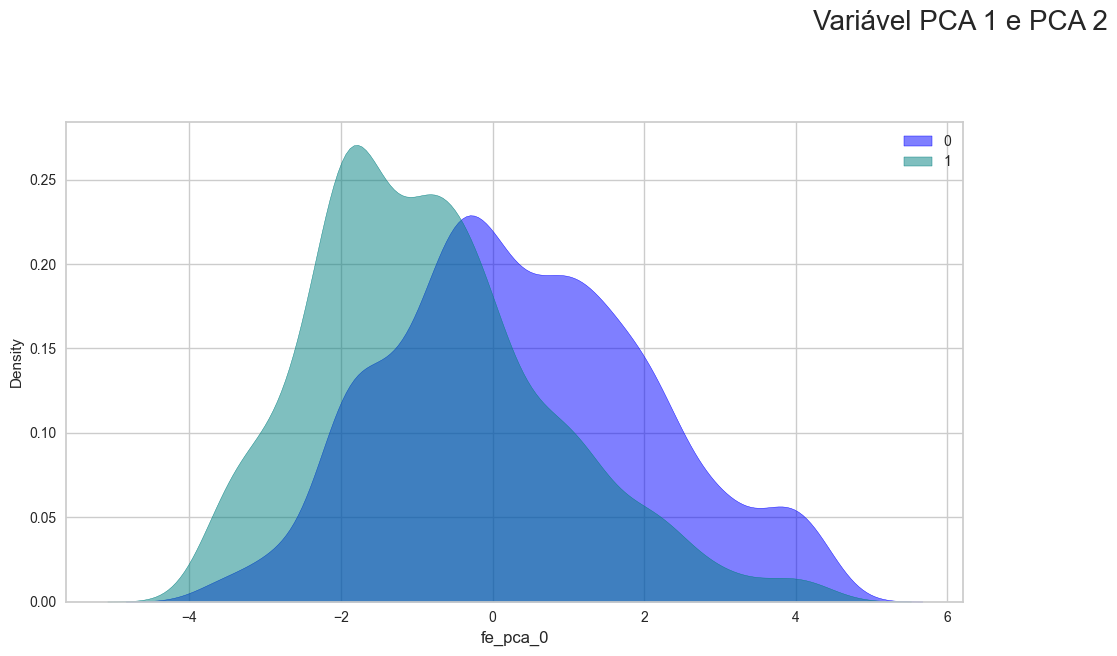

In [185]:
plt.figure(figsize=(20,7))

_ = df2_train.copy() 
_[target] = y 

for i,feature in enumerate([ 'fe_pca_0']):
    plt.subplot(1,2,i+1)
    sns.kdeplot(_[_[target]==0][feature],color='blue', alpha=0.5, label='0', shade=True)
    sns.kdeplot(_[_[target]==1][feature],color='teal', alpha=0.5, label='1', shade=True)  
    plt.xlabel(feature, fontsize=12)
    plt.legend()
         
plt.suptitle('Variável PCA 1 e PCA 2', fontsize=20)
plt.tight_layout(pad=3.0);

In [198]:
def grup_pca (df_): 
    df_['fe_pca_0_group']= np.inf
    df_['fe_pca_0_group'][(df_['fe_pca_0']<-2) ]  = 'gr_1'
    df_['fe_pca_0_group'][(df_['fe_pca_0']>=-2) & (df_['fe_pca_0']<=0)]= 'gr_2'
    df_['fe_pca_0_group'][(df_['fe_pca_0']>0) & (df_['fe_pca_0']<2)]  = 'gr_3'
    df_['fe_pca_0_group'][df_['fe_pca_0']>2]  = 'gr_4'

    df_.drop('fe_pca_0', axis=1, inplace=True)

    return df_

In [199]:
df2_train = grup_pca(df2_train)
df2_test = grup_pca(df2_test)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. PIPELINE </h1>    
</div>

In [206]:
df3_train = df2_train.copy()
df3_test  = df2_test.copy()
X         = df2_train.drop(target, axis=1)
y         = df2_train[target]
X_test    = df2_test.copy()

In [207]:
seed             = 12359
counter          = Counter(y)
scale_pos_weight = (counter[0]/counter[1]) 

params_xgb  = {
    'objective'        : 'binary:logistic', 
    'eval_metric'      : ['error', 'logloss'],
    'max_depth'        : 4, 
    'scale_pos_weight' : scale_pos_weight,
    'n_estimators'     : 500,    
    'learning_rate'    : .1,
    'colsample_bytree' : .75,    
    'subsample'        : .8,
    'reg_lambda'       : 100,
    'n_jobs'           : -1,    
    'seed'             : seed}
    
if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

# Classificadores
model_xgb  = xgb.XGBClassifier(**params_xgb)

In [208]:
class TargetEncoderCV(TargetEncoder):
    """Cross-fold target encoder.
    """
    # https://brendanhasz.github.io/2019/03/04/target-encoding.html
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle  = shuffle
        self.cols     = cols

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)        
        return self
    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix  = []
        self._fit_tes  = []
        kf             = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:],
                                            y[train_ix]))
            else:
                raise TypeError('X deve ser DataFrame ou ndarray')

        # Aplicar meios nas dobras
        Xo = X.copy()
        
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = \
                    self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = \
                    self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X deve ser DataFrame ou ndarray')
                
        return Xo
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [209]:
class TargetEncoderLOO(TargetEncoder):
    """Leave-one-out target encoder.
    """
    
    def __init__(self, cols=None):
        """Leave-one-out target encoding for categorical features.
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.
        """
        self.cols = cols
        
    def fit(self, X, y):
        """Fit leave-one-out target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to target encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.sum_count = dict()
        for col in self.cols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = \
                    (y[ix].sum(),ix.sum())
            
        # Return the fit object
        return self
    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses leave-one-out target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        # Create output dataframe
        Xo = X.copy()

        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = sum_count[0]/sum_count[1]
                Xo[col] = vals

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    vals[ix] = (sum_count[0]-y[ix])/(sum_count[1]-1)
                Xo[col] = vals
            
        # Return encoded DataFrame
        return Xo
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [210]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [216]:
seed     = 12359
cols_oho = ['trabalho', 'estado civil','atraso', 'casa', 'empréstimo', 'contato', 'anterior', 
            'fe_cluster_bgmm_pca'] 
cols_ord = ['educação', 'mês', 'dia', 'duração', 'idade_group', 'fe_pca_0_group']

In [217]:
#encoder = ce.PolynomialEncoder(cols=["fe_pca_0"])
#_ = encoder.fit_transform(X, verbose=1)

In [218]:
# https://pbpython.com/categorical-encoding.html
# https://brendanhasz.github.io/2019/03/04/target-encoding.html
encoder = ce.WOEEncoder(cols=['fe_cluster_bgmm_pca'], regularization=0, random_state=seed)


In [234]:
# Preprocessing data:
numerical_transformer = SimpleImputer(strategy='constant')
ordEncoder = OrdinalEncoder()

categorical_transformer = Pipeline(steps=[
    ('imp',SimpleImputer(strategy='constant', fill_value='No Data')),
    ('OHen',OneHotEncoder(handle_unknown='ignore',sparse=False))
])

categorical_transformer_woe = Pipeline(steps=[
    #('imp',SimpleImputer(strategy='constant', fill_value='No Data')),
    ('woe',ce.WOEEncoder(regularization=0, random_state=seed))
])

categorical_ord_transformer = Pipeline(steps=[
    ('imp',SimpleImputer(strategy='constant', fill_value='No Data')),
    ('Ord',ordEncoder)
])

num_transformer = Pipeline(steps=[    
    ('imputer', SimpleImputer(strategy='median')),
    #('featre_pca',ordEncoder)
])

num_transformer = Pipeline(steps=[    
    ('imputer', SimpleImputer(strategy='median')),
    #('featre_pca',ce.BackwardDifferenceEncoder(verbose=False, return_df=False))
])

    
processor=ColumnTransformer(
    transformers=[    
        ('ord', categorical_ord_transformer, cols_ord ),
        ('cat', categorical_transformer, cols_oho), 
        #('num', num_transformer, ['fe_pca_0']),
        ], 
    remainder='drop', 
    sparse_threshold=0.3
)

percentage = .5
over       = SMOTE(sampling_strategy='minority', k_neighbors=5, n_jobs=-1, random_state=seed) 
under      = RandomUnderSampler(sampling_strategy='all', random_state=seed) 
# https://www.kaggle.com/code/anilkay/handleimbalanceddataclassification


# Processamento
scaler            = ('preprocessor', StandardScaler())
variancethreshold = ('variancethreshold', VarianceThreshold(threshold=0.04)) 
selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=85))
selectKbest       = ('SelectKBest', SelectKBest(score_func=f_classif, k=12))

# Pipelne 
pipeline_processor = Pipeline(steps=[('processor', processor), 
                                     #('sampler_over',  over), 
                                     #('sampler_under', under),   
                                     variancethreshold, 
                                     selectpercentile, 
                                     scaler])

pipeline_xgb = Pipeline(steps=[('processor', pipeline_processor),
                               ('model', model_xgb)])
pipeline_xgb

Pipeline(steps=[('processor',
                 Pipeline(steps=[('processor',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='constant')),
                                                                                   ('Ord',
                                                                                    OrdinalEncoder())]),
                                                                   ['educação',
                                                                    'mês',
                                                                    'dia',
                                                                    'duração',
                                                                    'idade_group',
                                                                    'fe_pca_0_group']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='co...
                               eval_metric=['error', 'logloss'], gamma=0,
                               gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=500, n_jobs=-1, num_parallel_tree=1,
                               predictor='auto', random_state=12359,
                               reg_alpha=0, reg_lambda=100, ...))])

In [244]:
%%time 

models = [('XGB-1', pipeline_xgb, 1, 'xgb_fe_05_pipe_line', pipeline_processor, 15), 
          ('XGB-2', model_xgb, 4, 'xgb_nb_03', pipeline_processor, 15)
         ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X,
                 y_            = y, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True
                 #model_feature_= [model_xgb, pipeline_processor]
                )

# F1-score: 0.73252 - F1-Train: 0.76276 - L.Loss: 0.42406 - 0h 0m 9s
# F1-score: 0.73081 - F1-Train: 0.76413 - L.Loss: 0.42451 - 0h 0m 9s
# F1-score: 0.73370 - F1-Train: 0.76368 - L.Loss: 0.42459 - 0h 0m 9s


=> XGB-1
Fold 1 => F1-score: 0.76744 - F1-Train: 0.76188 - AUC:0.83677 - L.Loss: 0.39369 - 0h 0m 0s
Fold 2 => F1-score: 0.74178 - F1-Train: 0.76152 - AUC:0.81431 - L.Loss: 0.40021 - 0h 0m 0s
Fold 3 => F1-score: 0.72979 - F1-Train: 0.76420 - AUC:0.80513 - L.Loss: 0.42378 - 0h 0m 0s
Fold 4 => F1-score: 0.71616 - F1-Train: 0.76638 - AUC:0.79607 - L.Loss: 0.45421 - 0h 0m 0s
Fold 5 => F1-score: 0.73364 - F1-Train: 0.76021 - AUC:0.80658 - L.Loss: 0.40163 - 0h 0m 0s
Fold 6 => F1-score: 0.72284 - F1-Train: 0.76429 - AUC:0.80000 - L.Loss: 0.43851 - 0h 0m 0s
Fold 7 => F1-score: 0.75000 - F1-Train: 0.75987 - AUC:0.82237 - L.Loss: 0.40474 - 0h 0m 0s
Fold 8 => F1-score: 0.71141 - F1-Train: 0.76892 - AUC:0.78947 - L.Loss: 0.46702 - 0h 0m 0s
Fold 9 => F1-score: 0.72368 - F1-Train: 0.76474 - AUC:0.80132 - L.Loss: 0.44630 - 0h 0m 0s
Fold 10 => F1-score: 0.74023 - F1-Train: 0.76475 - AUC:0.81316 - L.Loss: 0.41583 - 0h 0m 0s
-------------------------------------------------------------------------------

,score
XGB-1,0.73370
XGB-2,0.72974



CPU times: total: 1min 34s
Wall time: 13.3 s


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;">4. TUNNING </h1>    
</div>

In [266]:
class LastPlacePruner(BasePruner):
    # https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/006_user_defined_pruner.html#sphx-glr-tutorial-20-recipes-006-user-defined-pruner-py    
    def __init__(self, warmup_steps, warmup_trials):
        self._warmup_steps = warmup_steps
        self._warmup_trials = warmup_trials

    def prune(self, study: "optuna.study.Study", trial: "optuna.trial.FrozenTrial") -> bool:
        # Obtenha a pontuação mais recente relatada neste teste
        step = trial.last_step

        if step:  # trial.last_step == None when no scores have been reported yet
            this_score = trial.intermediate_values[step]

            # Get scores from other trials in the study reported at the same step
            completed_trials = study.get_trials(deepcopy=False, states=(TrialState.COMPLETE,))
            other_scores = [
                t.intermediate_values[step]
                for t in completed_trials
                if step in t.intermediate_values
            ]
            other_scores = sorted(other_scores)

            # Prune if this trial at this step has a lower value than all completed trials
            # at the same step. Note that steps will begin numbering at 0 in the objective
            # function definition below.
            if step >= self._warmup_steps and len(other_scores) > self._warmup_trials:
                if this_score < other_scores[0]:
                    #print(f"prune() True: Trial {trial.number}, Step {step}, Score {this_score}")
                    return True

        return False

In [349]:
class TunningModels(): # nn.Module
        
    def __init__(self, name_model_, X_trn_, y_trn_, X_ts_, seed_=12359, 
                 target_='target', path_='', level_='1', sc_second_= None, 
                 n_splits_=10):
        
        super(TunningModels,self).__init__() 

        self.name_clf    = name_model
        self.X_trn       = X_trn_
        self.y_trn       = y_trn_
        self.X_ts        = X_ts_                 
        self.seed        = seed_
        self.target      = target_
        self.path        = path_
        self.level       = level_
        self.sc_second   = sc_second_
        self.n_splits    = n_splits_
        
    def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))
                        
    def xgb(self,  trial):

        # https://xgboost.readthedocs.io/en/latest/parameter.html
        # https://amangupta16.medium.com/xgboost-hyperparameters-explained-bb6ce580501d     

        counter          = Counter(y)
        scale_pos_weight = (counter[0]/counter[1]) 

        params = {'objective'         : trial.suggest_categorical('objective', ['binary:logistic']), 
                  #'booster'           : trial.suggest_categorical('booster', ['gbtree']),                 
                  #'eval_metric'       : trial.suggest_categorical('eval_metric', ['mlogloss']), 
                  'max_depth'         : trial.suggest_int('max_depth', 2, 15),                   
                  'n_estimators'      : trial.suggest_int('n_estimators', 100, 1500, 100),                                         
                  'learning_rate'     : trial.suggest_float('learning_rate', .001, 0.1),
                  'colsample_bytree'  : trial.suggest_float('colsample_bytree', 0.7, 1.0),
                  'subsample'         : trial.suggest_discrete_uniform('subsample', .7, 1.0, .05),
                  'reg_alpha'         : trial.suggest_int('reg_alpha', 1, 100, 10), 
                  'min_child_weight'  : trial.suggest_int('min_child_weight', 1, 50)
                 }

        params.update({'eval_metric'     : ['error', 'logloss'], 
                       'scale_pos_weight': scale_pos_weight, 
                       'n_jobs'          : -1,
                       'seed'            : self.seed})
            
        if torch.cuda.is_available():           
            params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
            

        #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")

        mdl = xgb.XGBClassifier(**params) #, callbacks=[pruning_callback])
        
        pipeline_xgb = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])
        
        random    = str(np.random.rand(1)[0]).replace('.','')
        name_file = self.name_clf + '_'+ format(random)

        models = [('XGB-1', pipeline_xgb, 1, name_file, pipeline_processor, 15)]

        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_       = models, 
                         X_            = self.X_trn,
                         y_            = self.y_trn, 
                         X_test_       = self.X_ts,                  
                         path_         = self.path, 
                         seed_         = self.seed,
                         target_       = self.path,
                         create_sub_   = True, 
                         n_splits_     = self.n_splits,
                         print_report_ = True, 
                         is_tunning_   = True
                        )

        #print('param = {}'.format(params))
        #print()

        return score

In [350]:
%%time

SEED       = 12359
n_trials_  = 100
name_model = 'xgb_001_tunning' 

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_     = name_model, 
                         X_trn_          = X, 
                         y_trn_          = y, 
                         X_ts_           = X_test,   
                         seed_           = SEED, 
                         target_         = target, 
                         path_           = path, 
                         n_splits_       = 10,
                         level_          = '1')

pruner = LastPlacePruner(warmup_steps  = 1, warmup_trials=5)
study  = optuna.create_study(direction  = 'maximize',
                             sampler    = optuna.samplers.TPESampler(seed=SEED),
                             pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                             #pruner     = pruner,
                             study_name = 'xgb_tuning'
                            )

study.optimize(modelOpt.xgb, n_trials=n_trials_)

score_seed  = study.best_value 
params      = study.best_params 
path_name   = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best  = score_seed 
params_best = params

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(SEED))
print('Parameters:\n\n{}'.format(params_best))
print()

[I 2022-12-20 01:32:06,263] A new study created in memory with name: xgb_tuning
[I 2022-12-20 01:32:12,934] Trial 0 finished with value: 0.71329 and parameters: {'objective': 'binary:logistic', 'max_depth': 6, 'n_estimators': 300, 'learning_rate': 0.03716909923114652, 'colsample_bytree': 0.9588812504618928, 'subsample': 0.7999999999999999, 'reg_alpha': 71, 'min_child_weight': 35}. Best is trial 0 with value: 0.71329.
[I 2022-12-20 01:32:42,133] Trial 1 finished with value: 0.73429 and parameters: {'objective': 'binary:logistic', 'max_depth': 7, 'n_estimators': 1200, 'learning_rate': 0.04219641981391001, 'colsample_bytree': 0.9619108642659173, 'subsample': 0.85, 'reg_alpha': 11, 'min_child_weight': 10}. Best is trial 1 with value: 0.73429.
[I 2022-12-20 01:33:04,001] Trial 2 finished with value: 0.72813 and parameters: {'objective': 'binary:logistic', 'max_depth': 13, 'n_estimators': 900, 'learning_rate': 0.0061565145914393255, 'colsample_bytree': 0.7933063078660557, 'subsample': 0.95, 

[I 2022-12-20 01:38:55,776] Trial 24 finished with value: 0.73459 and parameters: {'objective': 'binary:logistic', 'max_depth': 15, 'n_estimators': 700, 'learning_rate': 0.03184214055516173, 'colsample_bytree': 0.9755440495569462, 'subsample': 0.85, 'reg_alpha': 21, 'min_child_weight': 6}. Best is trial 21 with value: 0.73611.
[I 2022-12-20 01:39:09,364] Trial 25 finished with value: 0.72302 and parameters: {'objective': 'binary:logistic', 'max_depth': 15, 'n_estimators': 700, 'learning_rate': 0.02630313551983165, 'colsample_bytree': 0.9826677468854963, 'subsample': 0.8999999999999999, 'reg_alpha': 51, 'min_child_weight': 6}. Best is trial 21 with value: 0.73611.
[I 2022-12-20 01:39:15,849] Trial 26 finished with value: 0.71986 and parameters: {'objective': 'binary:logistic', 'max_depth': 15, 'n_estimators': 200, 'learning_rate': 0.014815256809865104, 'colsample_bytree': 0.9353064044009806, 'subsample': 0.7999999999999999, 'reg_alpha': 21, 'min_child_weight': 14}. Best is trial 21 with

[I 2022-12-20 01:45:57,509] Trial 48 finished with value: 0.73295 and parameters: {'objective': 'binary:logistic', 'max_depth': 10, 'n_estimators': 1100, 'learning_rate': 0.03794961561385505, 'colsample_bytree': 0.9911076544474061, 'subsample': 0.8999999999999999, 'reg_alpha': 31, 'min_child_weight': 9}. Best is trial 43 with value: 0.73772.
[I 2022-12-20 01:46:10,390] Trial 49 finished with value: 0.7212 and parameters: {'objective': 'binary:logistic', 'max_depth': 7, 'n_estimators': 900, 'learning_rate': 0.03301231784187344, 'colsample_bytree': 0.8117883881003798, 'subsample': 0.95, 'reg_alpha': 61, 'min_child_weight': 12}. Best is trial 43 with value: 0.73772.
[I 2022-12-20 01:46:36,169] Trial 50 finished with value: 0.7155 and parameters: {'objective': 'binary:logistic', 'max_depth': 5, 'n_estimators': 1300, 'learning_rate': 0.027459674604936507, 'colsample_bytree': 0.9503173648522888, 'subsample': 0.95, 'reg_alpha': 1, 'min_child_weight': 1}. Best is trial 43 with value: 0.73772.


[I 2022-12-20 01:51:53,146] Trial 72 finished with value: 0.73388 and parameters: {'objective': 'binary:logistic', 'max_depth': 7, 'n_estimators': 900, 'learning_rate': 0.0205350781574093, 'colsample_bytree': 0.8753530935795639, 'subsample': 0.85, 'reg_alpha': 21, 'min_child_weight': 29}. Best is trial 54 with value: 0.7381.
[I 2022-12-20 01:52:06,784] Trial 73 finished with value: 0.72631 and parameters: {'objective': 'binary:logistic', 'max_depth': 8, 'n_estimators': 700, 'learning_rate': 0.023050158833214547, 'colsample_bytree': 0.8432216056918372, 'subsample': 0.85, 'reg_alpha': 31, 'min_child_weight': 35}. Best is trial 54 with value: 0.7381.
[I 2022-12-20 01:52:22,180] Trial 74 finished with value: 0.73497 and parameters: {'objective': 'binary:logistic', 'max_depth': 7, 'n_estimators': 900, 'learning_rate': 0.06450969663310081, 'colsample_bytree': 0.8652134986650938, 'subsample': 0.85, 'reg_alpha': 21, 'min_child_weight': 33}. Best is trial 54 with value: 0.7381.
[I 2022-12-20 01

[I 2022-12-20 02:00:37,204] Trial 96 finished with value: 0.7366 and parameters: {'objective': 'binary:logistic', 'max_depth': 9, 'n_estimators': 1000, 'learning_rate': 0.016309651024260925, 'colsample_bytree': 0.8185105495593391, 'subsample': 0.7, 'reg_alpha': 11, 'min_child_weight': 14}. Best is trial 54 with value: 0.7381.
[I 2022-12-20 02:01:03,454] Trial 97 finished with value: 0.73623 and parameters: {'objective': 'binary:logistic', 'max_depth': 9, 'n_estimators': 1100, 'learning_rate': 0.015566630464829805, 'colsample_bytree': 0.8096079120395849, 'subsample': 0.7, 'reg_alpha': 11, 'min_child_weight': 13}. Best is trial 54 with value: 0.7381.
[I 2022-12-20 02:01:27,873] Trial 98 finished with value: 0.73679 and parameters: {'objective': 'binary:logistic', 'max_depth': 9, 'n_estimators': 1000, 'learning_rate': 0.009797611934271387, 'colsample_bytree': 0.8202586866386469, 'subsample': 0.7, 'reg_alpha': 11, 'min_child_weight': 12}. Best is trial 54 with value: 0.7381.
[I 2022-12-20 


--------------------------------------------------------------------------------------------------------------
Best score: 0.73810
Seed      : 12359
Parameters:

{'objective': 'binary:logistic', 'max_depth': 6, 'n_estimators': 700, 'learning_rate': 0.014365125187773168, 'colsample_bytree': 0.9905486921538615, 'subsample': 0.8999999999999999, 'reg_alpha': 11, 'min_child_weight': 15}

CPU times: total: 3h 42min 56s
Wall time: 29min 51s


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 5. Conclusão </h1>    
</div>